# *Assignment 1:*  

# Question 1. Download preprocessed single-cell gene expression data for ~4K PBMCs (peripheral blood cells) from a healthy donor.

In [2]:
# Load libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy 
from scipy import sparse
import scipy.io
from scipy.io import mmread


In [18]:
#load the scRNA seq mtx file
grch38_mtx = mmread('GRCh38/matrix.mtx')

In [20]:
grch38_mtx

<33694x4340 sparse matrix of type '<class 'numpy.int64'>'
	with 5727695 stored elements in COOrdinate format>

In [22]:
# load labels to read gene barcode files

import csv
grch38_barcodes = 'GRCh38/barcodes.tsv'
grch38_genes = 'GRCh38/genes.tsv'

barcodes = [row[0] for row in csv.reader(open(grch38_barcodes), delimiter="\t")]  
genes = [row[1].upper() for row in csv.reader(open(grch38_genes), delimiter="\t")]

** Q1a. ** Load the above data and construct a dense matrix of genes by cell from the sparse list format.  What is the shape of the matrix, how many cells and genes are detected? [15 pts]

In [24]:
# Question 1a.    
# Covert to a dense matrix
dense_grch38 = grch38.todense()
dense_grch38.shape   # genes * cells

(33694, 4340)

In [28]:
# Convert the dense matrix to a datafram
grch38_df = pd.DataFrame(data=dense_grch38,index = genes, columns=barcodes)
grch38_df.head()

# Test the location of some UMI count
#grch38_df.iloc(14382,1445)  ##What is happening here?  

# Find the log10 of the data for values>0
log_result = np.log10(grch38_df, where=(grch38_df!=0))

# Find the sum of each column(cells)
log_result_umi = np.sum(log_result,axis=0)

# Find the sum of each row (genes)
log_result_genes = np.sum(log_result,axis=1)

**Q1b.** Plot a histogram of log10 of library size (i.e. total counts per cell). Do you think the data
requires filtering of cell barcodes? If yes, how does the histogram look like after filtering? What
is the median of library size across all cells after any filtering [10 pts]?

In [29]:
# find the sum of each column(cells)
log_result_umi = np.sum(log_result,axis=0)

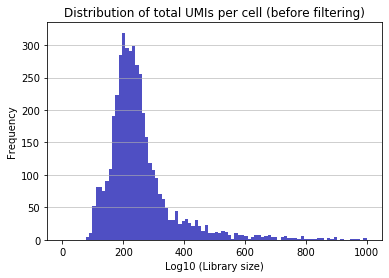

In [30]:
# plot histogram of unfiltered library size
n, bins, patches = plt.hist(x= log_result_umi, bins='auto',
                            range=[0, 1000],
                            color='#0504aa',
                            alpha=0.7, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Log10 (Library size)')
plt.ylabel('Frequency')
plt.title('Distribution of total UMIs per cell (before filtering)')
maxfreq = n.max()

# Marina's correction:
#import matplotlib.pyplot as plt
#library_size = #sum of all counts for a cell
#hist = plt.hist(np.log10(library_size), bins = np.arange(2.5 ,5, 0.05))
#plt.show()
# Once you plot the histogram you will filter it to reduce noise
# i.e. delete cells (columns) for wich log10(librarysize) < threshold

In [31]:
# filter the libary size to remove the upper tail
filtered_log_umi = log_result_umi[log_result_umi < 500]
umi_mask = log_result_umi.gt(500) # filter to remove umi greater than 500

#log_result[log_result.columns[umi_mask]]
filtered_result = log_result[log_result.columns[~ umi_mask]]

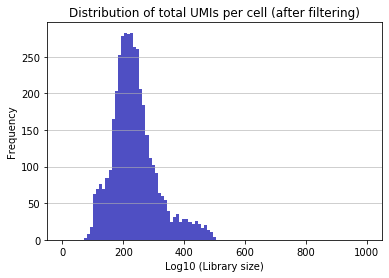

In [32]:
# plot histogram of filtered library size
n, bins, patches = plt.hist(x= filtered_log_umi , bins='auto',
                            range=[0, 1000],
                            color='#0504aa',
                            alpha=0.7, rwidth=1)
plt.ylim = (0,300)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Log10 (Library size)')
plt.ylabel('Frequency')
plt.title('Distribution of total UMIs per cell (after filtering)')
maxfreq = n.max()

In [33]:
# median of library size across all cells after any filtering
umi_median = filtered_log_umi.median()

**Q1c.** Plot a histogram of log10 of the total number cells that each gene is expressed in. Is this
distribution unimodal or multimodal? If the latter, how many genes remain if you filter the lower
mode as noisy genes [5 pts]?

In [34]:
# get the total no of cells that each gene is expressed in
cc = (grch38_df !=0).sum(1)

# # find the log10
cc_log = np.log10(cc,where=(cc!=0))

Text(0.5, 1.0, 'Cells per gene (before filtering)')

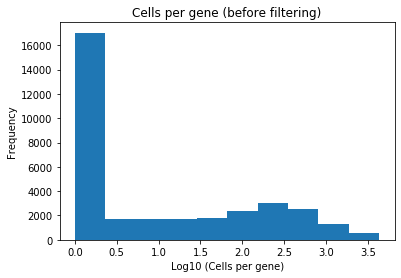

In [35]:
# Plot histogram before filtering
plt.hist(cc_log)
plt.xlabel('Log10 (Cells per gene)')
plt.ylabel('Frequency')
plt.title('Cells per gene (before filtering)')

The distribution is multimodal

In [36]:
# Filter the number of Genes based on distribution
# filter out genes that are expressed in less the log10(1) of cells
tmp = cc_log
tmp = tmp[tmp>1]

Text(0.5, 1.0, 'Cells per gene (after filtering)')

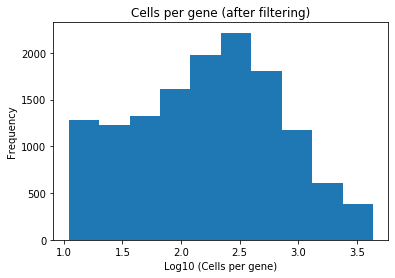

In [37]:
# Histogram of filtered Genes result
plt.hist(tmp)
plt.xlabel('Log10 (Cells per gene)')
plt.ylabel('Frequency')
plt.title('Cells per gene (after filtering)')

In [38]:
# no of genes before filtering
len(cc_log)

33694

In [39]:
# no of genes after filtering
len(tmp)

13628

In [42]:
# to obtain the filtered count matrix in a dataframe format
# filter out genes that are expressed in less the log10(1) of cells
gene_mask = cc_log.gt(1)
idx1 = gene_mask.index

# Filtered Count matrix of Genes and UMI
filtered_result = filtered_result[gene_mask]

/Users/kathrynwhyte/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


ValueError: cannot reindex from a duplicate axis

In [43]:
# For the linear Count matrix (all data is linear and not in log10)

# Filter the columns / cells
linear_filtered_result = grch38_df[log_result.columns[~ umi_mask]]
# Filter the number of genes
linear_filtered_result = linear_filtered_result[gene_mask]

# find the sum of each column (total UMI / library size)
total_counts = np.sum(linear_filtered_result,axis=0)

# Find the median of the library size
linear_umi_median = np.median(total_counts)

In [44]:
linear_umi_median

3794.0

# Q2 Normalize and visualize the data

**Q2a** Normalize the data with global scaling to the median library size.

Normalization = [(expression of gene A) / library size] * median library size (median UMI)

In [45]:
## global scaling to median library size = (row sum/library size)*median library size, and that code would be calling for sum of vector?
norm_result = (linear_filtered_result/total_counts) * linear_umi_median

** Q2b** Embed the normalized data to 2D using t-SNE or Umap or any other dimensionality reduction method. Justify your method of choice 
  <https://towardsdatascience.com/dimensionality-reduction-for-data-visualization-pca-vs-tsne-vs-umap-be4aa7b1cb29>

## UMAP



In [49]:
# import UMAP
import umap
from umap import UMAP
import plotly.express as px

ModuleNotFoundError: No module named 'umap'

In [ ]:
#train = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')
#train.head()

In [ ]:
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(linear_filtered_result)

fig_2d = px.scatter(proj_2d, x=0, y=1)
fig_2d.show()

In [ ]:
#start = time.time()
#reducer = umap.UMAP(random_state=42,n_components=3)
#embedding = reducer.fit_transform(x)
#print('Duration: {} seconds'.format(time.time() - start))

In [ ]:
# Setting the label and the feature columns
#y = train.loc[:,'label'].values
#x = train.loc[:,'pixel1':].values
#print(np.unique(y))

In [ ]:
# Visualising UMAP in 2d
#fig = plt.figure(figsize=(12,8))
#plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=y, cmap='gist_rainbow')
#plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(24)).set_ticks(np.arange(24))
#ax.set_xlabel('umap_1')
#ax.set_ylabel('umap_2')
#plt.title('Visualizing sign-language-mnist with UMAP in 2D', fontsize=24);

In [ ]:
# Visualising UMAP in 3d
#fig = plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1],reducer.embedding_[:, 2], c=y, cmap='gist_rainbow')
#ax.set_xlabel('umap_1')
#ax.set_ylabel('umap_2')
#ax.set_zlabel('umap_3')
#plt.title('Visualizing sign-language-mnist through UMAP in 3D', fontsize=24);
#plt.show()

In [ ]:
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)


# Plot UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(linear_filtered_result)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1])  #c=[sns.colors]
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of Grch38 data')


## t-SNE

start = time.time()
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x)
tsne = TSNE(random_state = 42, n_components=3,verbose=0, perplexity=40, n_iter=400).fit_transform(pca_result_50)
print(‘Duration: {} seconds’.format(time.time() — start))

# Visualising t-SNE 2D
fig = plt.figure(figsize=(12,8))
plt.scatter(tsne[:, 0], tsne[:, 1], c=y, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(24)).set_ticks(np.arange(24))
plt.title('Visualizing sign-language-mnist through t-SNE in 2D', fontsize=24);
plt.xlabel('tsne_1')
plt.ylabel('tsne_2')

# Visualising t-SNE 3D
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne[:, 0], tsne[:, 1],tsne[:,2], c=y, cmap='gist_rainbow')#ax.set_xlabel('tsne_1')
ax.set_ylabel('tsne_2')
ax.set_zlabel('tsne_3')
plt.title('Visualizing sign-language-mnist through TSNE in 3D', fontsize=24);
plt.show()


## Q2c Color cells in the embedded 2D map by log10 of library size. Interpret the plot

In [ ]:
#plt.colorbar(boundaries=np.arange(24)).set_ticks(np.arange(24)) ## not the log10 command I know

## Q2d Color cells in the 2D map by normalized expression of major immune cell markers. Which cell types can you detect?

In [ ]:
#plt.colorbar(boundaries=np.arange(24)).set_ticks(np.arange(24)) 
## now normalized expression = (row sum/librarysize) *median library size?  

## cell types detected by size; 
#PBMC = lymphocytes and monocytes by size? 
## once the data is normalized you can see what is gene is a housekeeping gene if it is the same across all cells

# Q3 Regress out library size using a linear regression model and redo Q2. Explain if/why you used a regularizer

In [ ]:
## import library sklearn for linear model:

#from sklearn import linear_model
#clf = linear_model.Lasso(alpha=0.1)
#clf.fit([[0,0], [1, 1], [2, 2]], [0, 1, 2])
#Lasso(alpha=0.1)
#print(clf.coef_)
#[0.85 0.  ]
#print(clf.intercept_)
#0.15...

#__init__(alpha=1.0, *, fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

#fit(X, y, sample_weight=None, check_input=True)
#get_params(deep=True)
#static path(X, y, *, |1_ration=0.5, eps=0.001, n_alphas=100, aphas=None, precompute='auto', Xy=None, copy_X=True, coef_init=None, verbose=False, return_n_iter=False, positive=False, check_input=True, **params)



### Then input where I have median, we normalize using regression coeff when in the above code the library size =0?

# Q4 Solve problem 3.12 of <https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf>

In [3]:
We saw in Section 2.3.6 that the conjugate prior for a Gaussian distribution
with unknown mean and unknown precision (inverse variance) is a normal-gamma
distribution. This property also holds for the case of the conditional Gaussian distribution p(t|x, w, β) of the linear regression model. If we consider the likelihood
function (3.10), then the conjugate prior for w and β is given by
p(w, β) = N (w|m0, β−1S0)Gam(β|a0, b0). (3.112)

Show that the corresponding posterior distribution takes the same functional form,
so that
p(w, β|t) = N (w|mN , β−1SN )Gam(β|aN , bN ) (3.113)
and find expressions for the posterior parameters mN , SN , aN , and bN .

#posterior distribution?

NameError: name 'pandas' is not defined